# Lista de Exercícios 3: Aproximação de Funções

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- ***SUBMISSÕES QUE NÃO SEGUIREM AS INSTRUÇÕES A SEGUIR NÃO SERÃO AVALIADAS.***
- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido antes de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps3.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 30/10/2025. Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Mountain Car

Mountain Car é um ambiente no qual um agente precisa conduzir um carro até o topo de uma montanha. No entanto, o motor do carro não é potente o suficiente para subir diretamente até o topo. Por isso, o agente precisa aprender a aproveitar o impulso - movendo-se para frente e para trás - para ganhar velocidade suficiente e alcançar o topo.

![](https://gymnasium.farama.org/_images/mountain_car.gif)

O espaço de observação é contínuo e composto por dois valores: a posição e a velocidade do carro. O agente pode escolher entre três ações discretas: acelerar o carro para a esquerda, acelerar para a direita, ou não acelerar. A posição inicial do agente é definida de forma uniformemente aleatória no intervalo $[-0.6, -0.4]$. O episódio se encerra quando o carro atinge o topo da montanha à direita (posição $0.5$) ou quando o limite de 200 passos é atingido. A cada passo, o agente recebe uma penalidade de $-1$, incentivando-o a alcançar o objetivo no menor número possível de passos. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Devido à natureza contínua do espaço de estados, métodos tabulares não são eficazes no Mountain Car. Assim, é comum o uso de técnicas de aproximação de função para solucionar o problema de forma eficiente. Nesta lista de exercícios, você irá trabalhar com o ambiente descrito acima. Seu objetivo será implementar o algoritmo *Semi-Gradient Episodic Sarsa* com aproximação linear e explorar como diferentes técnicas de construção de features influenciam o desempenho do agente.

## Semi-Gradient Episodic Sarsa

Nesta atividade, você implementará um agente baseado no algoritmo Semi-Gradient Episodic SARSA, utilizando uma **função de valor linear**.

Antes de iniciar sua implementação, analise a interface `FeatureExtractor` fornecida abaixo. Ela será a base para os construtores de features que você implementará na próxima seção. O agente utilizará um objeto com essa interface para extrair features a partir das observações dos estados.

In [1]:
from abc import ABC, abstractmethod

import numpy as np
import gymnasium as gym
import sklearn
import matplotlib.pyplot as plt

In [2]:
class FeatureExtractor(ABC):
    """
    Interface for feature extractors that convert environment states into feature vectors.
    """

    @property
    @abstractmethod
    def feature_size(self):
        """
        Property that returns the size of the feature vector produced by this extractor.

        Returns:
            An integer representing the length of the feature vector.
        """
        pass

    @abstractmethod
    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector.

        Args:
            state: The observation state from the environment.

        Returns:
            The extracted feature vector representation.
        """
        pass

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, um construtor de features (`feature_extractor`), a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `compute_q_values`, que recebe um vetor de features e calcula os *Q-values* de acordo com a entrada.
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [3]:
class SGESAgent:
    def __init__(self, observation_space, action_space, feature_extractor, alpha, gamma, epsilon):
        self.observation_space = observation_space
        self.action_space = action_space
        self.feature_extractor = feature_extractor
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon


        self.weights = np.zeros((self.feature_extractor.feature_size, self.action_space.n))

    def compute_q_values(self, features):
        return np.dot(features, self.weights)

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()
        else:
            features = self.feature_extractor.extract(state)
            q_values = self.compute_q_values(features)
            return np.argmax(q_values)

    def learn(self, state, action, reward, next_state, next_action, done):
        features = self.feature_extractor.extract(state)

        q_current = self.compute_q_values(features)[action]

        q_next = 0
        if not done:
            next_features = self.feature_extractor.extract(next_state)
            q_next = self.compute_q_values(next_features)[next_action]

        delta = reward + self.gamma * q_next - q_current

        self.weights[:, action] += self.alpha * delta * features

    def train(self, env, episodes):
        episode_returns = []
        for episode in range(episodes):
            state, _ = env.reset()
            action = self.choose_action(state)

            total_reward = 0
            terminated = False
            truncated = False

            while not (terminated or truncated):
                next_state, reward, terminated, truncated, _ = env.step(action)

                next_action = self.choose_action(next_state)

                done = terminated or truncated

                self.learn(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action

                total_reward += reward

            episode_returns.append(total_reward)

        return episode_returns

In [ ]:
# Não altere ou remova esta célula

In [ ]:
# Não altere ou remova esta célula

In [ ]:
# Não altere ou remova esta célula

In [ ]:
# Não altere ou remova esta célula

## Construção de Features

Com o algoritmo do agente pronto, você deverá implementar 3 modelos de construtores de features diferentes:

1. **Identidade**
2. **Tile Coding**
3. **Funções de Base Radial**

### Identidade

6. Implemente o `IdentityFeatureExtractor`, cujo método `extract` apenas retorna a observação de entrada, sem realizar nenhuma operação nela.

In [4]:
class IdentityFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space):
        self._observation_space = observation_space

    @property
    def feature_size(self):
        return self._observation_space.shape[0]

    def extract(self, state):
        return state

In [ ]:
# Não altere ou remova esta célula

7. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `IdentityFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `identity_agent`.

**Nota:** Não se preocupe se o desempenho do agente com o `IdentityFeatureExtractor` for insatisfatório. Ele será utilizado apenas como baseline, permitindo observar o comportamento do agente quando nenhuma transformação é aplicada às observações do ambiente.

In [7]:
env = gym.make("MountainCar-v0")

identity_extractor = IdentityFeatureExtractor(env.observation_space)

agent_identity = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=identity_extractor,
    alpha=0.01,
    gamma=0.99,
    epsilon=0.1
)

identity_agent = agent_identity.train(env, 200)

env.close()

mean_return = np.mean(identity_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(identity_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -200.00
Mean Return of the Last 20 Episodes: -200.00


In [ ]:
# Não altere ou remova esta célula

### Tile Coding

8. Implemente o `TileCodingFeatureExtractor`, cujo método `extract` gera um vetor de features utilizando a técnica de *tile coding*. A quantidade de tilings a ser gerada é definida pelo parâmetro `num_tilings`, enquanto a quantidade de divisões por dimensão em cada tiling é definida pelo parâmetro `tiles_per_dim`. Ambos valores são fornecidos ao construtor da classe. Por exemplo: um `TileCodingFeatureExtractor` com `num_tilings = 3` e `tiles_per_dim = 2` deve gerar 3 tilings, cada um dividindo o espaço em uma grade de tamanho 2$\times$2.

In [18]:
class TileCodingFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, num_tilings, tiles_per_dim):
        self.observation_space = observation_space
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.num_dims = len(observation_space.low)

        self.tiles_per_tiling = self.tiles_per_dim ** self.num_dims

        self._feature_size = self.num_tilings * self.tiles_per_tiling

        self.tile_sizes = (observation_space.high - observation_space.low) / self.tiles_per_dim

        tiling_indices = np.arange(self.num_tilings).reshape(-1, 1)
        displacement_per_tiling = self.tile_sizes / self.num_tilings
        self.offsets = tiling_indices * displacement_per_tiling

    @property
    def feature_size(self):
        return self._feature_size

    def extract(self, state):
        features = np.zeros(self.feature_size)
        dims = (self.tiles_per_dim,) * self.num_dims

        for i in range(self.num_tilings):
            shifted_state = state - self.observation_space.low + self.offsets[i]
            tile_coords = tuple(np.floor(shifted_state / self.tile_sizes).astype(int))

            local_index = np.ravel_multi_index(tile_coords, dims=dims, mode='clip')

            global_index = i * self.tiles_per_tiling + local_index

            features[global_index] = 1.0

        return features

In [16]:
# Não altere ou remova esta célula

9. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `TileCodingFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Para os parâmetros `num_tilings` e `tiles_per_dim`, utilize os valores que proporcionarem os melhores resultados. Armazene os retornos episódicos, obtidos no método `train`, na variável `tile_agent`.

In [28]:
env = gym.make("MountainCar-v0")

num_tilings = 16
tiles_per_dim = 10

tile_coding_extractor = TileCodingFeatureExtractor(
    observation_space=env.observation_space,
    num_tilings=num_tilings,
    tiles_per_dim=tiles_per_dim
)

alpha_scaled = 0.01 / num_tilings

agent_tile = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=tile_coding_extractor,
    alpha=alpha_scaled,
    gamma=0.99,
    epsilon=0.1
)

tile_agent = agent_tile.train(env, 400)

env.close()

mean_return = np.mean(tile_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(tile_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -200.00
Mean Return of the Last 20 Episodes: -200.00


In [ ]:
# Não altere ou remova esta célula

### Funções de Base Radial

10. Implemente o `RBFFeatureExtractor`, cujo método `extract` gera um conjunto de features baseadas em *Radial Basis Functions*. A quantidade total de componentes a ser gerada é definida pelo parâmetro `n_components`, fornecido ao construtor da classe. Utilize a biblioteca *scikit-learn* (sklearn) para auxiliar sua implementação.

**Importante:** Você pode combinar RBFs com diferentes parâmetros para capturar melhor dinâmicas complexas do ambiente e potencialmente melhorar o desempenho do agente. Experimente diferentes configurações para identificar as combinações que produzem os melhores resultados de aprendizado. Normalizar o vetor de entrada também pode facilitar o aprendizado.

In [24]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler

class RBFFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, n_components):
        self.observation_space = observation_space
        self._n_components = n_components

        samples = np.array([observation_space.sample() for _ in range(10000)])

        self.scaler = StandardScaler()
        self.scaler.fit(samples)

        self.rbf_sampler = RBFSampler(n_components=n_components, gamma=0.5)
        self.rbf_sampler.fit(self.scaler.transform(samples))

    @property
    def feature_size(self):
        return self._n_components

    def extract(self, state):
        state_reshaped = state.reshape(1, -1)

        scaled_state = self.scaler.transform(state_reshaped)

        rbf_features = self.rbf_sampler.transform(scaled_state)

        return rbf_features.flatten()

In [ ]:
# Não altere ou remova esta célula

11. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `RBFFeatureExtractor` com 100 componentes. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `rbf_agent`.

In [25]:
env = gym.make("MountainCar-v0")

rbf_extractor = RBFFeatureExtractor(
    observation_space=env.observation_space,
    n_components=100
)

agent_rbf = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=rbf_extractor,
    alpha=0.01,
    gamma=0.99,
    epsilon=0.1
)


rbf_agent = agent_rbf.train(env, 200)

env.close()

mean_return = np.mean(rbf_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(rbf_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -186.80
Mean Return of the Last 20 Episodes: -156.60


In [26]:
assert 'rbf_agent' in vars()

## Análise

12. Utilize a biblioteca matplotlib para construir um gráfico comparativo dos retornos episódicos obtidos pelos agentes utilizando cada um dos construtores de features implementados. Utilize as variáveis `identiy_agent`, `tile_agent` e `rbf_agent` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Caso seja necessário, aplique uma média movel para suavizar as curvas e deixar as tendências mais evidentes. Inclua título, legendas e rótulos de eixos apropriados para facilitar a interpretação. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

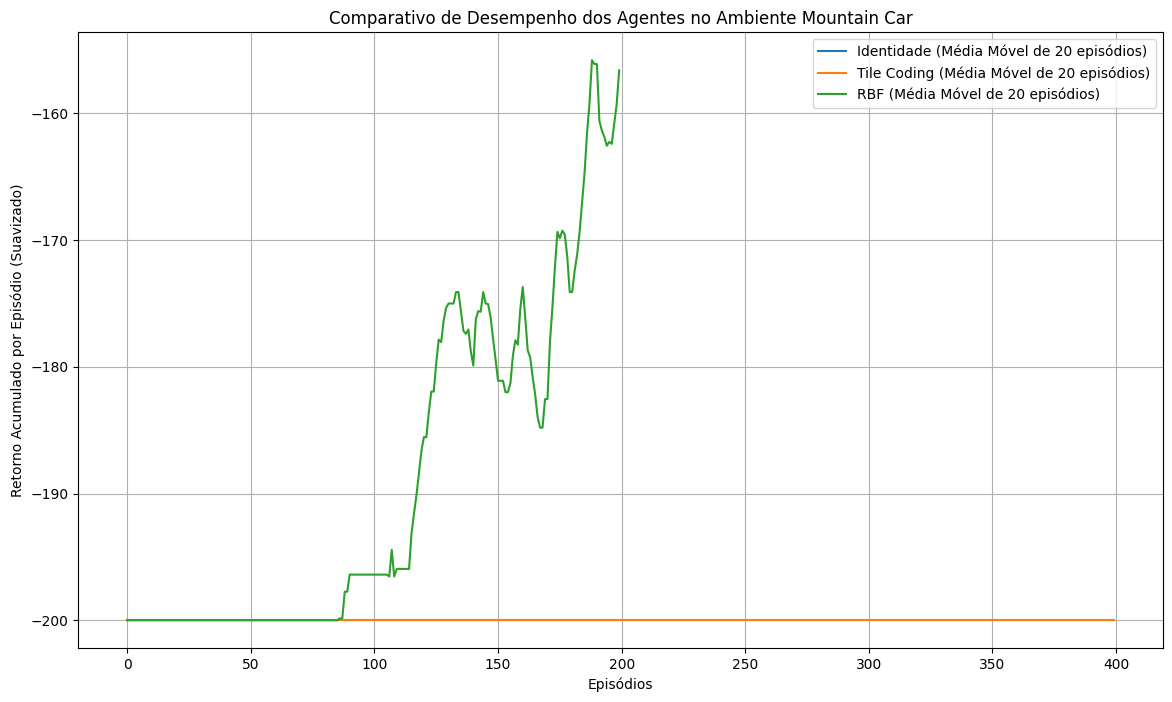

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

WINDOW_SIZE = 20

plt.figure(figsize=(14, 8))

identity_smoothed = pd.Series(identity_agent).rolling(WINDOW_SIZE, min_periods=1).mean()
tile_smoothed = pd.Series(tile_agent).rolling(WINDOW_SIZE, min_periods=1).mean()
rbf_smoothed = pd.Series(rbf_agent).rolling(WINDOW_SIZE, min_periods=1).mean()

plt.plot(identity_smoothed, label=f'Identidade (Média Móvel de {WINDOW_SIZE} episódios)')
plt.plot(tile_smoothed, label=f'Tile Coding (Média Móvel de {WINDOW_SIZE} episódios)')
plt.plot(rbf_smoothed, label=f'RBF (Média Móvel de {WINDOW_SIZE} episódios)')

plt.title('Comparativo de Desempenho dos Agentes no Ambiente Mountain Car')
plt.xlabel('Episódios')
plt.ylabel('Retorno Acumulado por Episódio (Suavizado)')

plt.legend()

plt.grid(True)

plt.show()

13. Explique por que a modelagem do construtor de features pode ser crucial para o desempenho de um agente que utiliza aproximação de função.

A modelagem do construtor de features é crucial porque ele define como o agente "enxerga" e compreende o ambiente, atuando como a base sobre a qual todo o conhecimento é construído. Um bom construtor transforma o espaço de estados complexo e contínuo em uma representação que torna o problema solucionável para um modelo de aproximação, especialmente um linear, ao capturar interações relevantes e permitir uma generalização inteligente entre estados semelhantes. Essas features servem como limite superior de quão bem o agente pode se sair.


14. Quais critérios devem guiar a escolha dos modelos e da quantidade de features a serem utilizadas na construção do espaço de features?

A escolha do modelo e da quantidade de features deve ser guiada pela capacidade de representação e a eficiência do aprendizado esperados, considerando a natureza do problema. Modelos como Tile Coding ou RBFs são eficazes para espaços de estado contínuos onde se deseja uma generalização local, ou seja, tratar estados próximos de forma semelhante. A quantidade de features, por sua vez, deve ser ajustada para fornecer resolução suficiente para distinguir estados que exigem ações diferentes, mas sem ser tão grande a ponto de sofrer com a maldição da dimensionalidade, o que tornaria o aprendizado muito lento e propenso a reproduzir ruído em vez de aprender como deveria. Portanto, o critério final é encontrar a granularidade mínima que captura a complexidade da função de valor ótima, garantindo que o agente possa aprender uma política refinada em um tempo razoável.